In [1]:
import sys
sys.path.append('./src')
import json
import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from backbones import OGBEmbedCINpp
from utils import get_data_loaders, set_seed, init_metric_dict, update_and_save_best_epoch_res, ExtractorMLP, get_optimizer, load_checkpoint
from trainer import run_one_epoch, get_viz_idx, visualize_results
from datetime import datetime
from torch.nn import functional as F
from baselines import LRIBern


/home/godfrey/anaconda3/envs/topo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using /home/godfrey/.cache/torch_extensions/py310_cu116 as PyTorch extensions root...
Emitting ninja build file /home/godfrey/.cache/torch_extensions/py310_cu116/pershom_cuda_ext/build.ninja...
Building extension module pershom_cuda_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module pershom_cuda_ext...


ninja: no work to do.


In [13]:
# dataset_name = 'ba_2motifs'
# dataset_name = 'ba_house_and_grid'
# dataset_name = 'spmotif_0.5'
# dataset_name = 'mutag'
dataset_name = 'benzene'
# dataset_name = 'ogbg_molhiv'
model_name = 'cinpp'

method_name = 'lri_bern'
cuda_id = 1
seed = 0
set_seed(seed)

In [14]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

model_config = {'num_layers': 3, 'emb_dim': 64, 'nonlinearity': 'relu', 'drop_rate': 0.3, 'readout': 'sum', 'final_readout':'sum', 'drop_position':'lin2',
                'graph_norm':'bn', 'atom_encoder':False}   
data_config = {'data_name': dataset_name, 'data_dir': '../data', 'max_ring_size': 6, 'include_down_adj': True, 'init_method': 'sum', 'n_jobs': 32}

method_config = {
    "one_encoder": True,
    "attn_constraint": "none",
    "temperature": 1.0,
    "decay_interval": 10,
    "decay_r": 0.1,
    "init_r": 0.7,
    "pred_loss_coef": 1.0,
    "pred_lr": 1.0e-3,
    "pred_wd": 1.0e-5,
    "dropout_p": 0.2,
    "norm_type": "batch",
    "act_type": "relu",
    'info_loss_coef': 0.1,
    'final_r': 0.7
}

optimizer_config = {
    "batch_size": 128,
    "wp_lr": 1.0e-3,
    "wp_wd": 1.0e-5,
    "attn_lr": 1.0e-3,
    "attn_wd": 1.0e-5,
    "emb_lr": 1.0e-3,
    "emb_wd": 1.0e-5
}

    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [15]:
loaders, dataset, test_set, x_dim, edge_attr_dim = get_data_loaders(dataset_name, batch_size=128, data_config=data_config)
# model_config['deg'] = aux_info['deg']

Loading dataset from disk...


In [16]:
clf = OGBEmbedCINpp(x_dim,
                    edge_attr_dim,
                    1,                       # out_size
                    model_config['num_layers'],                         # num_layers
                    model_config['emb_dim'],                            # hidden
                    dropout_rate=model_config['drop_rate'],             # dropout_rate
                    indropout_rate=0.0,         # in-dropout_rate
                    max_dim=2,                 # max_dim
                    jump_mode=None,                # jump_mode
                    nonlinearity=model_config['nonlinearity'],          # nonlinearity
                    readout=model_config['readout'],                    # readout
                    final_readout=model_config['final_readout'],        # final readout
                    apply_dropout_before=model_config['drop_position'], # where to apply dropout
                    use_coboundaries=True,       # whether to use coboundaries
                    embed_edge=True,       # whether to use edge feats
                    graph_norm=model_config['graph_norm'],              # normalization layer
                    readout_dims=(0, 1),              # readout_dims
                    atom_encoder=model_config["atom_encoder"]
                    ).to(device)

extractor = ExtractorMLP(model_config['emb_dim'], method_config)
extractor = extractor.to(device)
criterion = F.binary_cross_entropy_with_logits
baseline = LRIBern(clf, extractor, criterion, method_config)
optimizer = get_optimizer(clf, extractor, optimizer_config, method_config, warmup=False, slayer=baseline.readout, gaus=baseline.gaus)

In [7]:
warmup = 0
writer = None
topk = 1
report_dict = None
for epoch in range(20):
    train_res = run_one_epoch(baseline, optimizer, loaders['train'], epoch, 'train', warmup, seed, device, writer, method_name)
    valid_res = run_one_epoch(baseline, None, loaders['valid'], epoch, 'valid', warmup, seed, device, writer, method_name)
    test_res = run_one_epoch(baseline, None, loaders['test'], epoch, 'test', warmup, seed, device, writer, method_name)
    
    metric_dict = update_and_save_best_epoch_res(baseline, train_res, valid_res, test_res, metric_dict, epoch, model_dir, seed, topk, False, writer)
    report_dict = {k.replace('metric/best_', ''): v for k, v in metric_dict.items()}  # for better readability
print(json.dumps(report_dict, indent=4))

[Seed 0, Epoch: 0]: train done, loss: -4.996, pred: 0.184, v_info: 0.000, gas: 0.482, c_info: 0.000, tpl: -522.785, org_acc: 0.909, msk_acc: 0.924, org_auc: 0.971, msk_auc: 0.980, exp_auc: 0.540, bkg_attn: 0.495, sig_attn: 0.536, : 100%|██████████| 75/75 [03:00<00:00,  2.41s/it]
[Seed 0, Epoch: 0]: valid done, loss: -4.976, pred: 0.010, v_info: 0.000, gas: 0.423, c_info: 0.000, tpl: -502.789, org_acc: 0.898, msk_acc: 0.997, org_auc: 0.987, msk_auc: 1.000, exp_auc: 0.976, bkg_attn: 0.468, sig_attn: 0.929, : 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]
[Seed 0, Epoch: 0]: test  done, loss: -4.941, pred: 0.015, v_info: 0.000, gas: 0.419, c_info: 0.000, tpl: -499.783, org_acc: 0.892, msk_acc: 0.997, org_auc: 0.986, msk_auc: 0.999, exp_auc: 0.975, bkg_attn: 0.470, sig_attn: 0.924, : 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred Loss: 0.010, Best Val Pred AUROC: 0.976, Best Test Pred AUROC: 0.975, Best Test X AUROC: 0.999, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 1]: train done, loss: -7.287, pred: 0.034, v_info: 0.000, gas: 0.473, c_info: 0.000, tpl: -736.842, org_acc: 0.961, msk_acc: 0.991, org_auc: 0.989, msk_auc: 0.999, exp_auc: 0.660, bkg_attn: 0.403, sig_attn: 0.573, : 100%|██████████| 75/75 [02:53<00:00,  2.31s/it]
[Seed 0, Epoch: 1]: valid done, loss: -5.788, pred: 0.001, v_info: 0.000, gas: 0.411, c_info: 0.000, tpl: -583.038, org_acc: 0.992, msk_acc: 1.000, org_auc: 0.999, msk_auc: 1.000, exp_auc: 0.995, bkg_attn: 0.354, sig_attn: 0.918, : 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]
[Seed 0, Epoch: 1]: test  done, loss: -5.883, pred: 0.001, v_info: 0.000, gas: 0.419, c_info: 0.000, tpl: -592.662, org_acc: 0.998, msk_acc: 1.000, org_auc: 0.999, msk_auc: 1.000, exp_auc: 0.996, bkg_attn: 0.332, sig_attn: 0.914, : 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Seed 0, Epoch: 1]: Best Epoch: 1, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 0.995, Best Test Pred AUROC: 0.996, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 2]: train done, loss: -8.418, pred: 0.036, v_info: 0.000, gas: 0.462, c_info: 0.000, tpl: -850.025, org_acc: 0.963, msk_acc: 0.991, org_auc: 0.983, msk_auc: 0.999, exp_auc: 0.712, bkg_attn: 0.372, sig_attn: 0.601, : 100%|██████████| 75/75 [02:56<00:00,  2.35s/it]
[Seed 0, Epoch: 2]: valid done, loss: -7.430, pred: 0.013, v_info: 0.000, gas: 0.449, c_info: 0.000, tpl: -748.793, org_acc: 0.932, msk_acc: 0.998, org_auc: 0.979, msk_auc: 0.999, exp_auc: 0.979, bkg_attn: 0.365, sig_attn: 0.928, : 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]
[Seed 0, Epoch: 2]: test  done, loss: -7.256, pred: 0.027, v_info: 0.000, gas: 0.446, c_info: 0.000, tpl: -732.750, org_acc: 0.939, msk_acc: 0.996, org_auc: 0.985, msk_auc: 0.998, exp_auc: 0.979, bkg_attn: 0.365, sig_attn: 0.925, : 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


[Seed 0, Epoch: 2]: Best Epoch: 1, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 0.995, Best Test Pred AUROC: 0.996, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 3]: train done, loss: -10.577, pred: 0.021, v_info: 0.000, gas: 0.460, c_info: 0.000, tpl: -1064.351, org_acc: 0.965, msk_acc: 0.995, org_auc: 0.983, msk_auc: 0.999, exp_auc: 0.785, bkg_attn: 0.329, sig_attn: 0.654, : 100%|██████████| 75/75 [02:56<00:00,  2.35s/it]
[Seed 0, Epoch: 3]: valid done, loss: -10.126, pred: 0.008, v_info: 0.000, gas: 0.409, c_info: 0.000, tpl: -1017.564, org_acc: 0.953, msk_acc: 0.999, org_auc: 0.979, msk_auc: 1.000, exp_auc: 0.988, bkg_attn: 0.324, sig_attn: 0.928, : 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]
[Seed 0, Epoch: 3]: test  done, loss: -10.114, pred: 0.008, v_info: 0.000, gas: 0.406, c_info: 0.000, tpl: -1016.199, org_acc: 0.964, msk_acc: 1.000, org_auc: 0.985, msk_auc: 1.000, exp_auc: 0.987, bkg_attn: 0.327, sig_attn: 0.925, : 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


[Seed 0, Epoch: 3]: Best Epoch: 1, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 0.995, Best Test Pred AUROC: 0.996, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 4]: train done, loss: -14.879, pred: 0.030, v_info: 0.000, gas: 0.454, c_info: 0.000, tpl: -1495.367, org_acc: 0.966, msk_acc: 0.993, org_auc: 0.987, msk_auc: 0.999, exp_auc: 0.759, bkg_attn: 0.274, sig_attn: 0.557, : 100%|██████████| 75/75 [02:52<00:00,  2.30s/it]
[Seed 0, Epoch: 4]: valid done, loss: -13.228, pred: 0.017, v_info: 0.000, gas: 0.460, c_info: 0.000, tpl: -1329.103, org_acc: 0.927, msk_acc: 0.998, org_auc: 0.982, msk_auc: 1.000, exp_auc: 0.966, bkg_attn: 0.203, sig_attn: 0.891, : 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]
[Seed 0, Epoch: 4]: test  done, loss: -13.261, pred: 0.012, v_info: 0.000, gas: 0.457, c_info: 0.000, tpl: -1331.896, org_acc: 0.939, msk_acc: 0.998, org_auc: 0.992, msk_auc: 0.999, exp_auc: 0.962, bkg_attn: 0.204, sig_attn: 0.882, : 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


[Seed 0, Epoch: 4]: Best Epoch: 1, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 0.995, Best Test Pred AUROC: 0.996, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 5]: train done, loss: -22.006, pred: 0.057, v_info: 0.000, gas: 0.465, c_info: 0.000, tpl: -2210.957, org_acc: 0.927, msk_acc: 0.988, org_auc: 0.978, msk_auc: 0.998, exp_auc: 0.754, bkg_attn: 0.194, sig_attn: 0.436, : 100%|██████████| 75/75 [02:52<00:00,  2.29s/it]
[Seed 0, Epoch: 5]: valid done, loss: -19.154, pred: 0.011, v_info: 0.000, gas: 0.445, c_info: 0.000, tpl: -1920.914, org_acc: 0.667, msk_acc: 0.999, org_auc: 0.924, msk_auc: 0.999, exp_auc: 0.941, bkg_attn: 0.191, sig_attn: 0.821, : 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]
[Seed 0, Epoch: 5]: test  done, loss: -19.307, pred: 0.014, v_info: 0.000, gas: 0.441, c_info: 0.000, tpl: -1936.513, org_acc: 0.652, msk_acc: 0.999, org_auc: 0.945, msk_auc: 0.999, exp_auc: 0.933, bkg_attn: 0.194, sig_attn: 0.809, : 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


[Seed 0, Epoch: 5]: Best Epoch: 1, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 0.995, Best Test Pred AUROC: 0.996, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 6]: train done, loss: -33.348, pred: 0.054, v_info: 0.000, gas: 0.480, c_info: 0.000, tpl: -3345.023, org_acc: 0.870, msk_acc: 0.990, org_auc: 0.985, msk_auc: 0.997, exp_auc: 0.752, bkg_attn: 0.121, sig_attn: 0.314, : 100%|██████████| 75/75 [02:51<00:00,  2.29s/it]
[Seed 0, Epoch: 6]: valid done, loss: -30.064, pred: 0.006, v_info: 0.000, gas: 0.412, c_info: 0.000, tpl: -3011.121, org_acc: 0.712, msk_acc: 0.999, org_auc: 0.983, msk_auc: 1.000, exp_auc: 0.924, bkg_attn: 0.160, sig_attn: 0.755, : 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
[Seed 0, Epoch: 6]: test  done, loss: -30.540, pred: 0.011, v_info: 0.000, gas: 0.407, c_info: 0.000, tpl: -3059.193, org_acc: 0.683, msk_acc: 0.998, org_auc: 0.986, msk_auc: 0.999, exp_auc: 0.912, bkg_attn: 0.162, sig_attn: 0.740, : 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


[Seed 0, Epoch: 6]: Best Epoch: 1, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 0.995, Best Test Pred AUROC: 0.996, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 7]: train done, loss: -43.707, pred: 0.020, v_info: 0.000, gas: 0.496, c_info: 0.000, tpl: -4377.726, org_acc: 0.784, msk_acc: 0.996, org_auc: 0.979, msk_auc: 0.999, exp_auc: 0.843, bkg_attn: 0.061, sig_attn: 0.285, : 100%|██████████| 75/75 [02:52<00:00,  2.29s/it]
[Seed 0, Epoch: 7]: valid done, loss: -35.472, pred: 0.311, v_info: 0.000, gas: 0.471, c_info: 0.000, tpl: -3583.055, org_acc: 0.558, msk_acc: 0.822, org_auc: 0.949, msk_auc: 1.000, exp_auc: 0.996, bkg_attn: 0.114, sig_attn: 0.941, : 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]
[Seed 0, Epoch: 7]: test  done, loss: -35.558, pred: 0.310, v_info: 0.000, gas: 0.465, c_info: 0.000, tpl: -3591.492, org_acc: 0.564, msk_acc: 0.818, org_auc: 0.941, msk_auc: 1.000, exp_auc: 0.996, bkg_attn: 0.115, sig_attn: 0.937, : 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


[Seed 0, Epoch: 7]: Best Epoch: 7, Best Val Pred Loss: 0.311, Best Val Pred AUROC: 0.996, Best Test Pred AUROC: 0.996, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 8]: train done, loss: -43.313, pred: 0.035, v_info: 0.000, gas: 0.497, c_info: 0.000, tpl: -4339.769, org_acc: 0.724, msk_acc: 0.991, org_auc: 0.993, msk_auc: 0.998, exp_auc: 0.900, bkg_attn: 0.031, sig_attn: 0.267, : 100%|██████████| 75/75 [02:50<00:00,  2.27s/it]
[Seed 0, Epoch: 8]: valid done, loss: -3.772, pred: 0.006, v_info: 0.000, gas: 0.482, c_info: 0.000, tpl: -382.614, org_acc: 0.843, msk_acc: 1.000, org_auc: 0.997, msk_auc: 1.000, exp_auc: 0.999, bkg_attn: 0.075, sig_attn: 0.912, : 100%|██████████| 10/10 [00:13<00:00,  1.40s/it]
[Seed 0, Epoch: 8]: test  done, loss: -3.710, pred: 0.006, v_info: 0.000, gas: 0.481, c_info: 0.000, tpl: -376.386, org_acc: 0.846, msk_acc: 1.000, org_auc: 0.997, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.074, sig_attn: 0.914, : 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


[Seed 0, Epoch: 8]: Best Epoch: 8, Best Val Pred Loss: 0.006, Best Val Pred AUROC: 0.999, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 9]: train done, loss: -4.489, pred: 0.006, v_info: 0.000, gas: 0.476, c_info: 0.000, tpl: -454.227, org_acc: 0.749, msk_acc: 0.999, org_auc: 0.991, msk_auc: 1.000, exp_auc: 0.934, bkg_attn: 0.032, sig_attn: 0.353, : 100%|██████████| 75/75 [02:52<00:00,  2.30s/it]
[Seed 0, Epoch: 9]: valid done, loss: -3.160, pred: 0.020, v_info: 0.000, gas: 0.466, c_info: 0.000, tpl: -322.725, org_acc: 0.587, msk_acc: 1.000, org_auc: 0.991, msk_auc: 1.000, exp_auc: 0.999, bkg_attn: 0.101, sig_attn: 0.968, : 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]
[Seed 0, Epoch: 9]: test  done, loss: -3.159, pred: 0.020, v_info: 0.000, gas: 0.462, c_info: 0.000, tpl: -322.598, org_acc: 0.590, msk_acc: 1.000, org_auc: 0.995, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.101, sig_attn: 0.967, : 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


[Seed 0, Epoch: 9]: Best Epoch: 8, Best Val Pred Loss: 0.006, Best Val Pred AUROC: 0.999, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 10]: train done, loss: -4.693, pred: 0.007, v_info: 0.000, gas: 0.461, c_info: 0.000, tpl: -474.627, org_acc: 0.682, msk_acc: 0.998, org_auc: 0.989, msk_auc: 1.000, exp_auc: 0.939, bkg_attn: 0.033, sig_attn: 0.381, : 100%|██████████| 75/75 [02:54<00:00,  2.33s/it]
[Seed 0, Epoch: 10]: valid done, loss: -3.462, pred: 0.210, v_info: 0.000, gas: 0.498, c_info: 0.000, tpl: -372.204, org_acc: 0.585, msk_acc: 0.978, org_auc: 0.994, msk_auc: 1.000, exp_auc: 0.999, bkg_attn: 0.056, sig_attn: 0.936, : 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
[Seed 0, Epoch: 10]: test  done, loss: -3.493, pred: 0.200, v_info: 0.000, gas: 0.495, c_info: 0.000, tpl: -374.264, org_acc: 0.599, msk_acc: 0.985, org_auc: 0.996, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.056, sig_attn: 0.936, : 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


[Seed 0, Epoch: 10]: Best Epoch: 10, Best Val Pred Loss: 0.210, Best Val Pred AUROC: 0.999, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 11]: train done, loss: -5.259, pred: 0.006, v_info: 0.000, gas: 0.449, c_info: 0.000, tpl: -531.007, org_acc: 0.807, msk_acc: 0.999, org_auc: 0.988, msk_auc: 1.000, exp_auc: 0.939, bkg_attn: 0.032, sig_attn: 0.374, : 100%|██████████| 75/75 [02:49<00:00,  2.26s/it]
[Seed 0, Epoch: 11]: valid done, loss: -3.846, pred: 0.134, v_info: 0.000, gas: 0.508, c_info: 0.000, tpl: -403.155, org_acc: 0.827, msk_acc: 0.983, org_auc: 0.992, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.055, sig_attn: 0.977, : 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
[Seed 0, Epoch: 11]: test  done, loss: -4.041, pred: 0.096, v_info: 0.000, gas: 0.504, c_info: 0.000, tpl: -418.747, org_acc: 0.812, msk_acc: 0.984, org_auc: 0.998, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.056, sig_attn: 0.977, : 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


[Seed 0, Epoch: 11]: Best Epoch: 11, Best Val Pred Loss: 0.134, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 12]: train done, loss: -5.684, pred: 0.007, v_info: 0.000, gas: 0.434, c_info: 0.000, tpl: -573.462, org_acc: 0.873, msk_acc: 0.999, org_auc: 0.986, msk_auc: 1.000, exp_auc: 0.931, bkg_attn: 0.038, sig_attn: 0.379, : 100%|██████████| 75/75 [02:52<00:00,  2.30s/it]
[Seed 0, Epoch: 12]: valid done, loss: -7.568, pred: 0.018, v_info: 0.000, gas: 0.463, c_info: 0.000, tpl: -763.232, org_acc: 0.951, msk_acc: 0.993, org_auc: 0.991, msk_auc: 1.000, exp_auc: 0.993, bkg_attn: 0.066, sig_attn: 0.816, : 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]
[Seed 0, Epoch: 12]: test  done, loss: -7.671, pred: 0.007, v_info: 0.000, gas: 0.459, c_info: 0.000, tpl: -772.358, org_acc: 0.943, msk_acc: 0.999, org_auc: 0.995, msk_auc: 1.000, exp_auc: 0.993, bkg_attn: 0.065, sig_attn: 0.808, : 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


[Seed 0, Epoch: 12]: Best Epoch: 11, Best Val Pred Loss: 0.134, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 13]: train done, loss: -11.408, pred: 0.012, v_info: 0.000, gas: 0.422, c_info: 0.000, tpl: -1146.166, org_acc: 0.884, msk_acc: 0.998, org_auc: 0.988, msk_auc: 1.000, exp_auc: 0.928, bkg_attn: 0.041, sig_attn: 0.391, : 100%|██████████| 75/75 [02:52<00:00,  2.30s/it]
[Seed 0, Epoch: 13]: valid done, loss: -8.703, pred: 0.000, v_info: 0.000, gas: 0.431, c_info: 0.000, tpl: -874.660, org_acc: 0.772, msk_acc: 1.000, org_auc: 0.995, msk_auc: 1.000, exp_auc: 0.996, bkg_attn: 0.075, sig_attn: 0.781, : 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]
[Seed 0, Epoch: 13]: test  done, loss: -8.674, pred: 0.000, v_info: 0.000, gas: 0.425, c_info: 0.000, tpl: -871.682, org_acc: 0.762, msk_acc: 1.000, org_auc: 0.997, msk_auc: 1.000, exp_auc: 0.996, bkg_attn: 0.075, sig_attn: 0.771, : 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Seed 0, Epoch: 13]: Best Epoch: 11, Best Val Pred Loss: 0.134, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 14]: train done, loss: -15.112, pred: 0.017, v_info: 0.000, gas: 0.409, c_info: 0.000, tpl: -1516.966, org_acc: 0.899, msk_acc: 0.997, org_auc: 0.998, msk_auc: 0.999, exp_auc: 0.911, bkg_attn: 0.041, sig_attn: 0.341, : 100%|██████████| 75/75 [02:52<00:00,  2.30s/it]
[Seed 0, Epoch: 14]: valid done, loss: -14.246, pred: 0.001, v_info: 0.000, gas: 0.460, c_info: 0.000, tpl: -1429.281, org_acc: 0.946, msk_acc: 1.000, org_auc: 1.000, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.058, sig_attn: 0.876, : 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]
[Seed 0, Epoch: 14]: test  done, loss: -14.259, pred: 0.001, v_info: 0.000, gas: 0.456, c_info: 0.000, tpl: -1430.554, org_acc: 0.950, msk_acc: 1.000, org_auc: 1.000, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.059, sig_attn: 0.883, : 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


[Seed 0, Epoch: 14]: Best Epoch: 14, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 15]: train done, loss: -16.021, pred: 0.003, v_info: 0.000, gas: 0.411, c_info: 0.000, tpl: -1606.470, org_acc: 0.915, msk_acc: 0.999, org_auc: 0.994, msk_auc: 1.000, exp_auc: 0.933, bkg_attn: 0.032, sig_attn: 0.346, : 100%|██████████| 75/75 [02:51<00:00,  2.29s/it]
[Seed 0, Epoch: 15]: valid done, loss: -15.170, pred: 0.001, v_info: 0.000, gas: 0.489, c_info: 0.000, tpl: -1521.910, org_acc: 0.654, msk_acc: 1.000, org_auc: 0.989, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.055, sig_attn: 0.968, : 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]
[Seed 0, Epoch: 15]: test  done, loss: -15.236, pred: 0.000, v_info: 0.000, gas: 0.484, c_info: 0.000, tpl: -1528.521, org_acc: 0.671, msk_acc: 1.000, org_auc: 0.992, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.056, sig_attn: 0.971, : 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Seed 0, Epoch: 15]: Best Epoch: 14, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 16]: train done, loss: -16.559, pred: 0.008, v_info: 0.000, gas: 0.408, c_info: 0.000, tpl: -1660.780, org_acc: 0.891, msk_acc: 0.998, org_auc: 0.997, msk_auc: 1.000, exp_auc: 0.929, bkg_attn: 0.028, sig_attn: 0.314, : 100%|██████████| 75/75 [02:49<00:00,  2.26s/it]
[Seed 0, Epoch: 16]: valid done, loss: -12.327, pred: 0.000, v_info: 0.000, gas: 0.484, c_info: 0.000, tpl: -1237.531, org_acc: 0.620, msk_acc: 1.000, org_auc: 0.986, msk_auc: 1.000, exp_auc: 0.999, bkg_attn: 0.047, sig_attn: 0.906, : 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]
[Seed 0, Epoch: 16]: test  done, loss: -12.148, pred: 0.000, v_info: 0.000, gas: 0.482, c_info: 0.000, tpl: -1219.679, org_acc: 0.635, msk_acc: 1.000, org_auc: 0.991, msk_auc: 1.000, exp_auc: 0.999, bkg_attn: 0.048, sig_attn: 0.918, : 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


[Seed 0, Epoch: 16]: Best Epoch: 14, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 17]: train done, loss: -16.966, pred: 0.005, v_info: 0.000, gas: 0.403, c_info: 0.000, tpl: -1701.124, org_acc: 0.790, msk_acc: 0.999, org_auc: 0.996, msk_auc: 1.000, exp_auc: 0.927, bkg_attn: 0.027, sig_attn: 0.304, : 100%|██████████| 75/75 [02:53<00:00,  2.31s/it]
[Seed 0, Epoch: 17]: valid done, loss: -13.213, pred: 0.000, v_info: 0.000, gas: 0.500, c_info: 0.000, tpl: -1326.270, org_acc: 0.598, msk_acc: 1.000, org_auc: 0.997, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.040, sig_attn: 0.922, : 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
[Seed 0, Epoch: 17]: test  done, loss: -12.765, pred: 0.000, v_info: 0.000, gas: 0.497, c_info: 0.000, tpl: -1281.457, org_acc: 0.603, msk_acc: 1.000, org_auc: 1.000, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.040, sig_attn: 0.931, : 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


[Seed 0, Epoch: 17]: Best Epoch: 14, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 18]: train done, loss: -17.993, pred: 0.004, v_info: 0.000, gas: 0.400, c_info: 0.000, tpl: -1803.686, org_acc: 0.869, msk_acc: 0.999, org_auc: 0.994, msk_auc: 1.000, exp_auc: 0.927, bkg_attn: 0.025, sig_attn: 0.290, : 100%|██████████| 75/75 [02:51<00:00,  2.29s/it]
[Seed 0, Epoch: 18]: valid done, loss: -14.906, pred: 0.006, v_info: 0.000, gas: 0.487, c_info: 0.000, tpl: -1496.021, org_acc: 0.542, msk_acc: 0.999, org_auc: 0.829, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.045, sig_attn: 0.914, : 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]
[Seed 0, Epoch: 18]: test  done, loss: -13.985, pred: 0.000, v_info: 0.000, gas: 0.481, c_info: 0.000, tpl: -1403.343, org_acc: 0.527, msk_acc: 1.000, org_auc: 0.834, msk_auc: 1.000, exp_auc: 1.000, bkg_attn: 0.046, sig_attn: 0.916, : 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


[Seed 0, Epoch: 18]: Best Epoch: 14, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 19]: train done, loss: -17.208, pred: 0.014, v_info: 0.000, gas: 0.402, c_info: 0.000, tpl: -1726.220, org_acc: 0.826, msk_acc: 0.997, org_auc: 0.992, msk_auc: 0.999, exp_auc: 0.937, bkg_attn: 0.022, sig_attn: 0.296, : 100%|██████████| 75/75 [02:54<00:00,  2.32s/it]
[Seed 0, Epoch: 19]: valid done, loss: -14.224, pred: 0.009, v_info: 0.000, gas: 0.471, c_info: 0.000, tpl: -1428.073, org_acc: 0.738, msk_acc: 0.998, org_auc: 0.988, msk_auc: 1.000, exp_auc: 0.995, bkg_attn: 0.043, sig_attn: 0.871, : 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]
[Seed 0, Epoch: 19]: test  done, loss: -13.998, pred: 0.005, v_info: 0.000, gas: 0.464, c_info: 0.000, tpl: -1405.011, org_acc: 0.714, msk_acc: 0.998, org_auc: 0.983, msk_auc: 1.000, exp_auc: 0.997, bkg_attn: 0.043, sig_attn: 0.859, : 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


[Seed 0, Epoch: 19]: Best Epoch: 14, Best Val Pred Loss: 0.001, Best Val Pred AUROC: 1.000, Best Test Pred AUROC: 1.000, Best Test X AUROC: 1.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
{
    "clf_epoch": 14,
    "clf_valid_loss": 0.000501628514030017,
    "clf_train": 0.9113530953566432,
    "clf_valid": 0.9998488033666988,
    "clf_test": 0.9998120066874698,
    "x_roc_train": 0.9993134064221217,
    "x_roc_valid": 1.0,
    "x_roc_test": 1.0
}


In [17]:
# best_epoch = report_dict['clf_epoch']
load_checkpoint(baseline, model_dir, model_name='model', map_location=device)

In [42]:
num_viz_samples = 2

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)

In [45]:
from utils.get_data_loaders import DataLoader
from trainer import eval_one_batch
for class_idx, (idx, tag) in enumerate(all_viz_set):
        viz_set = test_set[idx]
        data = next(iter(DataLoader(viz_set, batch_size=len(idx), shuffle=False)))
        # data = process_data(data, use_edge_attr)
        _, _, _, _, batch_att, _ = eval_one_batch(baseline, None, data.to(baseline.device), 500, False, None, method_name)
        top_5_values, top_5_indices = torch.topk(batch_att, 20)
        print("最大20个值", top_5_values)
        print("相应的索引", top_5_indices)

最大20个值 tensor([1.0000, 0.9731, 0.9229, 0.9229, 0.9044, 0.7755, 0.7273, 0.6341, 0.6341,
        0.5858, 0.5358, 0.5094, 0.4843, 0.2703, 0.2544, 0.2437, 0.2422, 0.2386,
        0.2290, 0.2290])
相应的索引 tensor([21, 19, 39, 38, 23,  1, 24, 37, 40, 10,  9, 20, 31, 17, 34,  4, 18, 11,
        35, 36])
最大20个值 tensor([1.0000, 0.9999, 0.9646, 0.9646, 0.9466, 0.9440, 0.9440, 0.9423, 0.9423,
        0.9398, 0.9130, 0.9089, 0.2378, 0.2116, 0.1952, 0.1919, 0.1445, 0.1266,
        0.1100, 0.1028])
相应的索引 tensor([ 9,  3, 39, 40,  7, 44, 41, 43, 42,  2,  6,  4, 24, 22, 33, 23, 34, 27,
        25, 26])


100%|██████████| 2/2 [00:00<00:00, 12.94it/s]


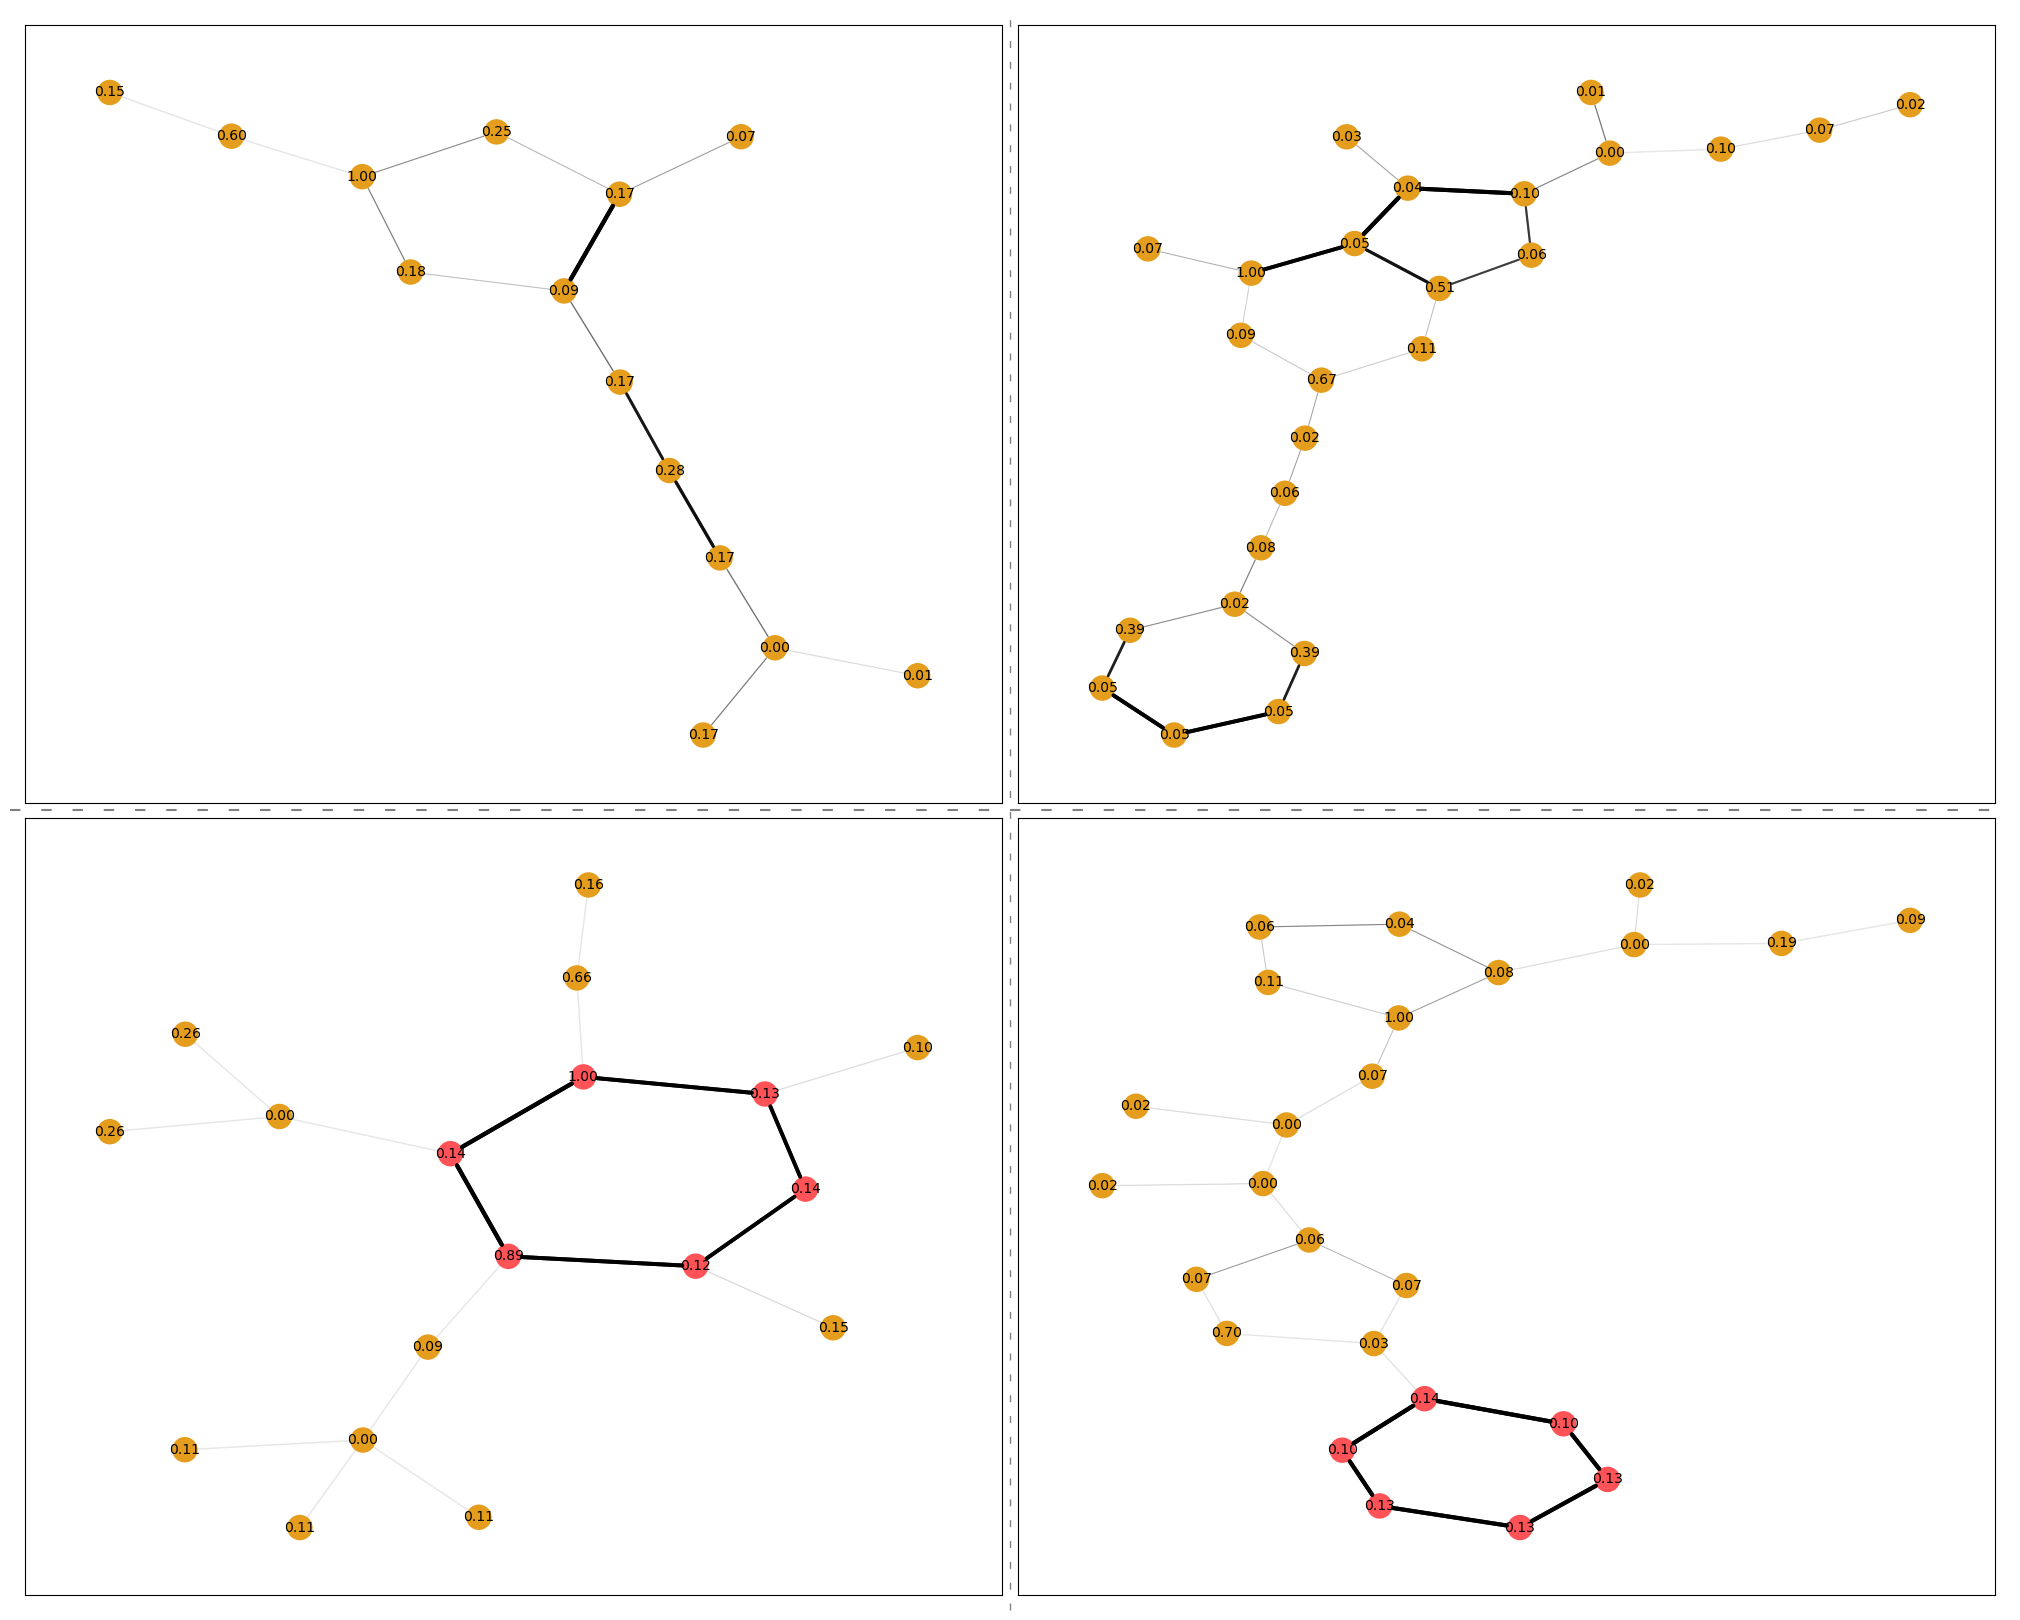

In [43]:
%matplotlib inline
visualize_results(baseline, all_viz_set, test_set, num_viz_samples, dataset_name, None, method_name)
#gsat, all_viz_set, test_set, num_viz_samples, dataset_name, optimizer, method_name